In [4]:
import numpy as np
import pandas as pd


# modelling
from sklearn.model_selection import train_test_split


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score,roc_auc_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/telecom_users_clean.csv')

In [6]:
!pip install --pre pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
df=df.drop(columns=['customerID'])

In [9]:
X = df.iloc[:,:-1]
y = df['Churn']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=19, stratify=y)

In [11]:
cat_cols=X_train.select_dtypes(include=['object']).columns.tolist()

In [12]:
X_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
2312,Male,Yes,Yes,No,59,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),64.05
4618,Male,No,Yes,No,55,No,No phone service,DSL,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),54.55
1789,Male,No,Yes,Yes,59,Yes,No,DSL,No,Yes,Yes,Yes,Yes,Yes,One year,No,Credit card (automatic),76.75
347,Female,No,Yes,No,64,Yes,No,DSL,No,Yes,Yes,Yes,No,Yes,Two year,Yes,Mailed check,68.30
903,Female,No,Yes,No,45,Yes,No,Fiber optic,No,No,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),95.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2732,Female,No,No,No,4,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),50.55
3433,Male,No,No,No,4,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check,90.05
956,Female,No,Yes,No,42,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,50.25
1235,Male,No,Yes,Yes,65,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),104.10


In [13]:
len(X_train.columns)

18

In [14]:
d=[X_train.columns.get_loc(c) for c in cat_cols]

In [15]:
len(d)

16

In [16]:
from sklearn.preprocessing import normalize
from pycaret.classification import *
from imblearn.over_sampling import SMOTENC

smotenc=SMOTENC(d,random_state=7)

reg = setup(data=pd.concat([X_train,y_train],axis=1), 
            target = 'Churn', 
            categorical_features=cat_cols,         
            session_id=13, fix_imbalance=True, fix_imbalance_method=smotenc,
            remove_multicollinearity=True, multicollinearity_threshold=0.8,      
            experiment_name='test1',
            n_jobs=-1)

,Description,Value
0,Session id,13
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(4788, 19)"
5,Transformed data shape,"(6363, 34)"
6,Transformed train set shape,"(4926, 34)"
7,Transformed test set shape,"(1437, 34)"
8,Ordinal features,6
9,Numeric features,2


Model1: ADA

In [17]:
best_model = compare_models(fold=10, sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7923,0.8384,0.6284,0.6044,0.6155,0.4735,0.4741,1.1270
ada,Ada Boost Classifier,0.7780,0.8349,0.6700,0.5692,0.6152,0.4607,0.4640,0.7560
lr,Logistic Regression,0.7499,0.8255,0.7422,0.5198,0.6112,0.4353,0.4505,2.4080
lda,Linear Discriminant Analysis,0.7437,0.8255,0.7579,0.5119,0.6108,0.4305,0.4490,0.5340
ridge,Ridge Classifier,0.7431,0.0000,0.7590,0.5112,0.6107,0.4299,0.4487,0.4310
nb,Naive Bayes,0.7377,0.8204,0.7466,0.5039,0.6014,0.4169,0.4351,0.7440
lightgbm,Light Gradient Boosting Machine,0.7863,0.8262,0.5598,0.6036,0.5803,0.4374,0.4384,0.7590
knn,K Neighbors Classifier,0.6956,0.7669,0.7310,0.4546,0.5601,0.3466,0.3698,1.2180
rf,Random Forest Classifier,0.7747,0.8059,0.5159,0.5833,0.5464,0.3977,0.3996,1.0590
et,Extra Trees Classifier,0.7490,0.7797,0.4990,0.5290,0.5123,0.3439,0.3449,1.0300


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [18]:
ada = create_model('ada', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7887,0.8541,0.6742,0.5882,0.6283,0.4816,0.4838
1,0.7463,0.7987,0.6364,0.5138,0.5685,0.3917,0.3962
2,0.8060,0.8615,0.6705,0.6211,0.6448,0.5116,0.5123
3,0.7701,0.8572,0.6629,0.5566,0.6051,0.4448,0.4481
4,0.8209,0.8759,0.7753,0.6330,0.6970,0.5717,0.5776
5,0.7761,0.8109,0.6404,0.5700,0.6032,0.4480,0.4495
6,0.8060,0.8762,0.7416,0.6111,0.6701,0.5344,0.5395
7,0.7552,0.7963,0.6629,0.5315,0.5900,0.4185,0.4237
8,0.7731,0.8229,0.6629,0.5619,0.6082,0.4501,0.4532


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
ada

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=13)

In [20]:
ada.get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [21]:
prediction_df = predict_model(ada, data=X_test)
predictions = prediction_df['prediction_label']
print(classification_report(y_test, predictions))

pd.DataFrame(confusion_matrix(y_test, predictions))


              precision    recall  f1-score   support

          No       0.89      0.80      0.84       880
         Yes       0.57      0.72      0.64       318

    accuracy                           0.78      1198
   macro avg       0.73      0.76      0.74      1198
weighted avg       0.80      0.78      0.79      1198



,0,1
0,707,173
1,89,229


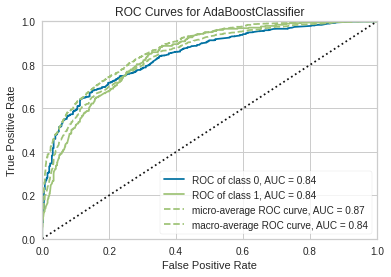

In [22]:
plot_model(ada)

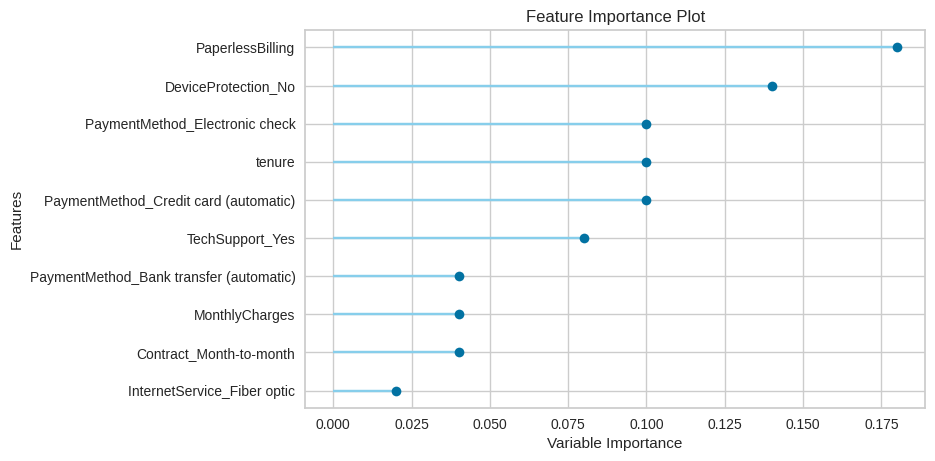

In [23]:
plot_model(ada, plot='feature')

In [24]:
interpret_model(ada, plot='msa')

In [ ]:
save_model(ada,'ada_model')

In [26]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import shap

In [28]:
saved_model = load_model('ada_model')

Transformation Pipeline and Model Successfully Loaded


In [29]:
train_pipe = saved_model[:-1].transform(X_train)
explainer = shap.TreeExplainer(saved_model.named_steps["trained_model"])
shap_values = explainer.shap_values(train_pipe)

InvalidModelError: ignored

Model2: GBC

In [30]:
gbc = create_model('gbc', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8006,0.8616,0.6404,0.6196,0.6298,0.4934,0.4936
1,0.7701,0.8091,0.6364,0.5545,0.5926,0.4336,0.4356
2,0.8179,0.8712,0.6818,0.6452,0.6630,0.5384,0.5388
3,0.7940,0.8608,0.6180,0.6111,0.6145,0.4740,0.4740
4,0.8239,0.8694,0.6742,0.6667,0.6704,0.5502,0.5502
5,0.7642,0.8070,0.4944,0.5641,0.5269,0.3708,0.3722
6,0.8418,0.8801,0.7191,0.6957,0.7072,0.5988,0.5990
7,0.7701,0.7979,0.6292,0.5600,0.5926,0.4333,0.4347
8,0.7761,0.8150,0.6180,0.5729,0.5946,0.4403,0.4409


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [31]:
prediction_df_gbc = predict_model(gbc, data=X_test)
predictions_gbc = prediction_df_gbc['prediction_label']
print(classification_report(y_test, predictions_gbc))
pd.DataFrame(confusion_matrix(y_test, predictions_gbc))

              precision    recall  f1-score   support

          No       0.87      0.84      0.86       880
         Yes       0.60      0.66      0.63       318

    accuracy                           0.79      1198
   macro avg       0.74      0.75      0.74      1198
weighted avg       0.80      0.79      0.80      1198



,0,1
0,743,137
1,109,209


In [ ]:
plot_model(gbc)

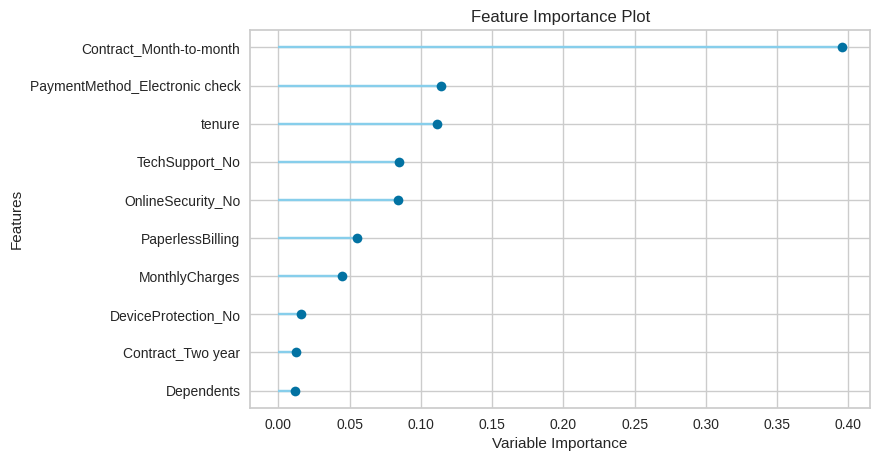

In [36]:
plot_model(gbc, plot='feature')

In [33]:
save_model(gbc,'gbc_model')
saved_model = load_model('gbc_model')
train_pipe = saved_model[:-1].transform(X_train)
explainer = shap.TreeExplainer(saved_model.named_steps["trained_model"])
shap_values = explainer.shap_values(train_pipe)

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


In [34]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0,:], train_pipe.iloc[0,:])

In [52]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[10,:], train_pipe.iloc[10,:])

In [48]:
len(shap_values[0]), X_test.shape

(33, (1198, 18))

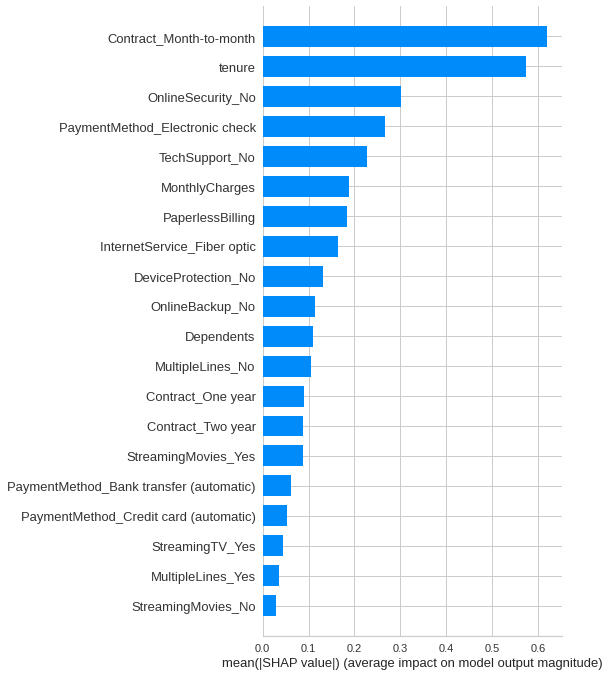

In [50]:
shap.summary_plot(shap_values,train_pipe, plot_type='bar')

In [51]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, train_pipe)

Output hidden; open in https://colab.research.google.com to view.

In [37]:
lr = create_model('lr', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7619,0.8467,0.7753,0.5349,0.6330,0.4655,0.4830
1,0.7104,0.7799,0.7273,0.4672,0.5689,0.3661,0.3865
2,0.7881,0.8620,0.7955,0.5691,0.6635,0.5150,0.5303
3,0.7612,0.8521,0.7528,0.5360,0.6262,0.4579,0.4722
4,0.7791,0.8611,0.8090,0.5581,0.6606,0.5049,0.5240
5,0.7433,0.8068,0.7303,0.5118,0.6019,0.4210,0.4354
6,0.7642,0.8580,0.7865,0.5385,0.6393,0.4731,0.4918
7,0.7403,0.7851,0.7079,0.5081,0.5915,0.4086,0.4207
8,0.7403,0.8126,0.7079,0.5081,0.5915,0.4086,0.4207


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [38]:
prediction_df_lr = predict_model(lr, data=X_test)
predictions_lr = prediction_df_lr['prediction_label']
print(classification_report(y_test, predictions_lr))
pd.DataFrame(confusion_matrix(y_test, predictions_lr))

              precision    recall  f1-score   support

          No       0.90      0.75      0.82       880
         Yes       0.52      0.77      0.62       318

    accuracy                           0.75      1198
   macro avg       0.71      0.76      0.72      1198
weighted avg       0.80      0.75      0.76      1198



,0,1
0,657,223
1,74,244


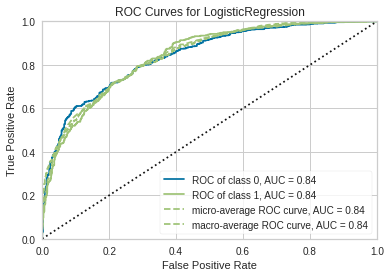

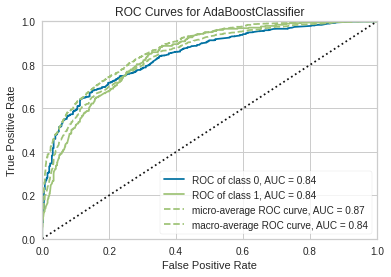

(None, None)

In [39]:
plot_model(lr),plot_model(ada)

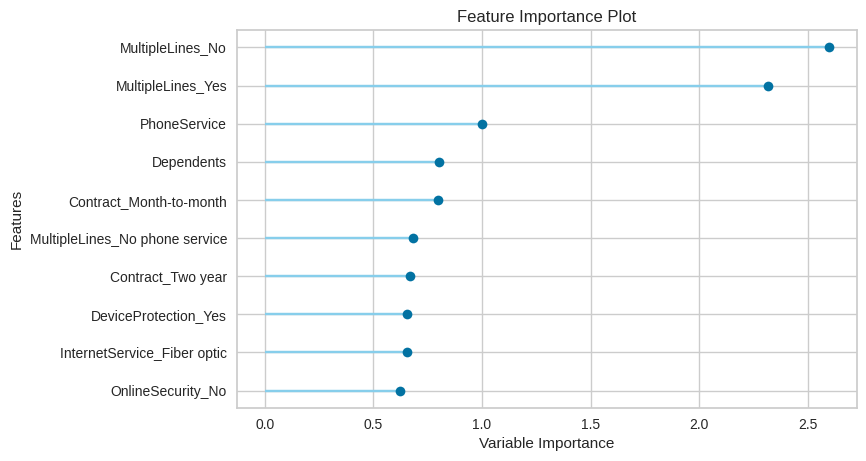

In [40]:
plot_model(lr, plot='feature')

In [ ]:
reg2 = setup(data=pd.concat([X_train,y_train],axis=1), 
            target = 'Churn',          
            session_id=13, fix_imbalance=True,
            remove_multicollinearity=True, 
            multicollinearity_threshold = 0.8,      
            experiment_name='test2',
            n_jobs=-1)

In [ ]:
best_model2 = compare_models(fold=10, sort='F1')

In [ ]:
lr = create_model('lr', fold=10)

In [ ]:
prediction_df_lr = predict_model(lr, data=X_test)
predictions_lr = prediction_df_lr['prediction_label']
print(classification_report(y_test, predictions_lr))
pd.DataFrame(confusion_matrix(y_test, predictions_lr))

In [ ]:
from imblearn.over_sampling import ADASYN



reg3 = setup(data=pd.concat([X_train,y_train],axis=1), 
            target = 'Churn',          
            session_id=13, fix_imbalance=True, fix_imbalance_method='ADASYN',
            remove_multicollinearity=True, 
            multicollinearity_threshold = 0.8,      
            experiment_name='test3',
            n_jobs=-1)

In [ ]:
best_model3 = compare_models(fold=10, sort='F1')

In [ ]:
lr2 = create_model('lr', fold=10)

In [ ]:
prediction_df_lr = predict_model(lr2, data=X_test)
predictions_lr = prediction_df_lr['prediction_label']
print(classification_report(y_test, predictions_lr))
pd.DataFrame(confusion_matrix(y_test, predictions_lr))

In [ ]:
from imblearn.over_sampling import RandomOverSampler



reg3 = setup(data=pd.concat([X_train,y_train],axis=1), 
            target = 'Churn',          
            session_id=13, fix_imbalance=True, fix_imbalance_method='RandomOverSampler',
            remove_multicollinearity=True, 
            multicollinearity_threshold = 0.8,      
            experiment_name='test3',
            n_jobs=-1)

In [ ]:
best_model4 = compare_models(fold=10, sort='F1')

In [ ]:
gbc=create_model('gbc',fold=10)

In [ ]:
prediction_df_gbc = predict_model(gbc, data=X_test)
predictions_gbc = prediction_df_gbc['prediction_label']
print(classification_report(y_test, predictions_gbc))
pd.DataFrame(confusion_matrix(y_test, predictions_gbc))